<a href="https://colab.research.google.com/github/subhadeep-sg/wheres-waldo/blob/main/Where's_Waldo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#cv2.imread causes sessions to crash... importing google's suggested library
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading input and reference image of Waldo

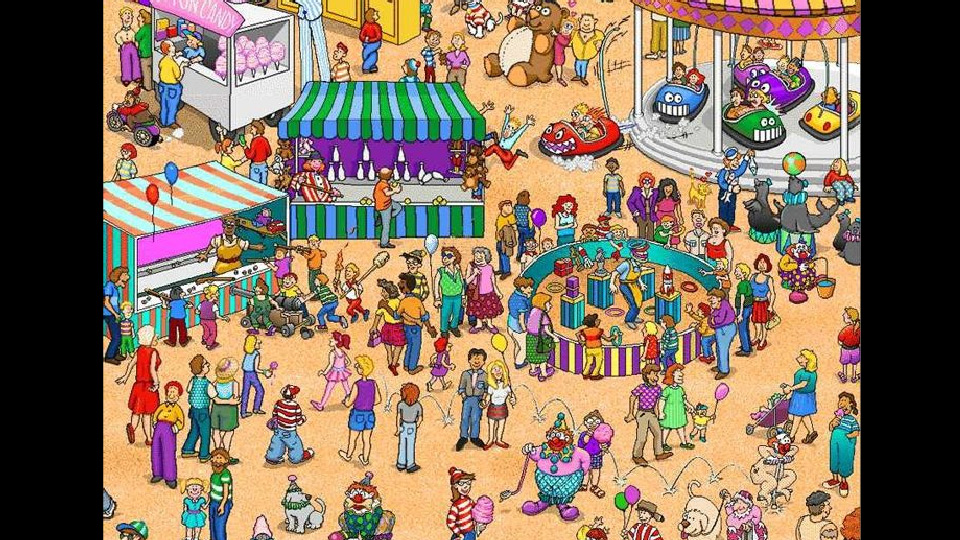

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Personal_Projects/Waldo/Dataset/waldo1.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ref = cv2.imread('/content/drive/MyDrive/Personal_Projects/Waldo/Dataset/ref_waldo.jpg')
#ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
cv2_imshow(img)
cv2.waitKey()
cv2.destroyAllWindows()

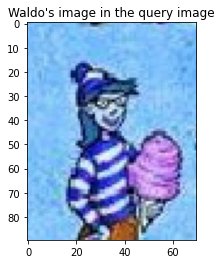

In [ ]:
plt.title('Waldo\'s image in the query image')
plt.imshow(img[450:600,430:500,:])

In [ ]:
cv2.imwrite('extract.jpg',img[450:600,430:500,:])
extract = img[450:600,430:500,:]

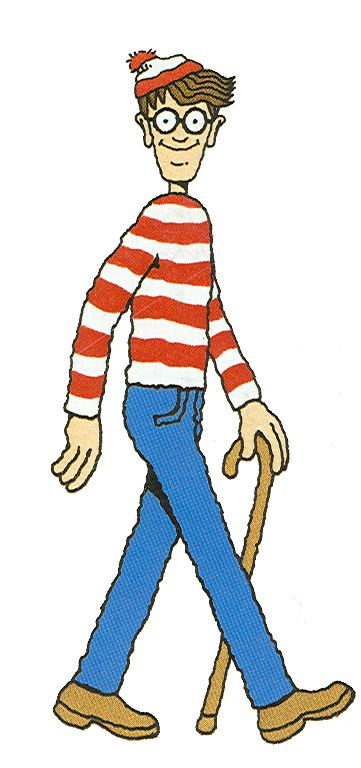

In [ ]:
cv2_imshow(ref)

In [ ]:
print(img.shape)
print(ref.shape)

(540, 960, 3)
(768, 361, 3)


# First Approach: <br>
Using a brute force ORB algorithm<br>
ORB (Oriented **FAST** and Rotated **BRIEF**) <br>
FAST = Features from Accelerated Segmented Test(*Used to find keypoints*)<br>
BRIEF = Binary Robust Independent Elementary Features(*Used to find descriptors*) <br>
[Reference](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html)

In [ ]:
orb = cv2.ORB_create()

Obtaining keypoints and descriptors

In [ ]:
kp1 , des1 = orb.detectAndCompute(img,None)
kp2 , des2 = orb.detectAndCompute(ref,None)

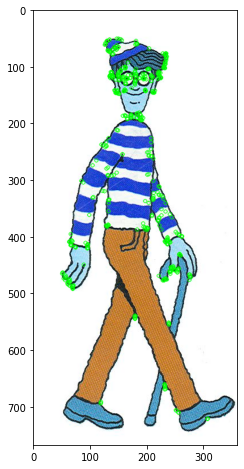

In [ ]:
train_kp = cv2.drawKeypoints(ref,kp2,0,color=(0,255,0),flags=0)
plt.figure(figsize=(8,8))
plt.imshow(train_kp)

### Building matcher

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)

In [ ]:
matches = bf.match(des1,des2)

In [ ]:
matches = sorted(matches,key = lambda x:x.distance)

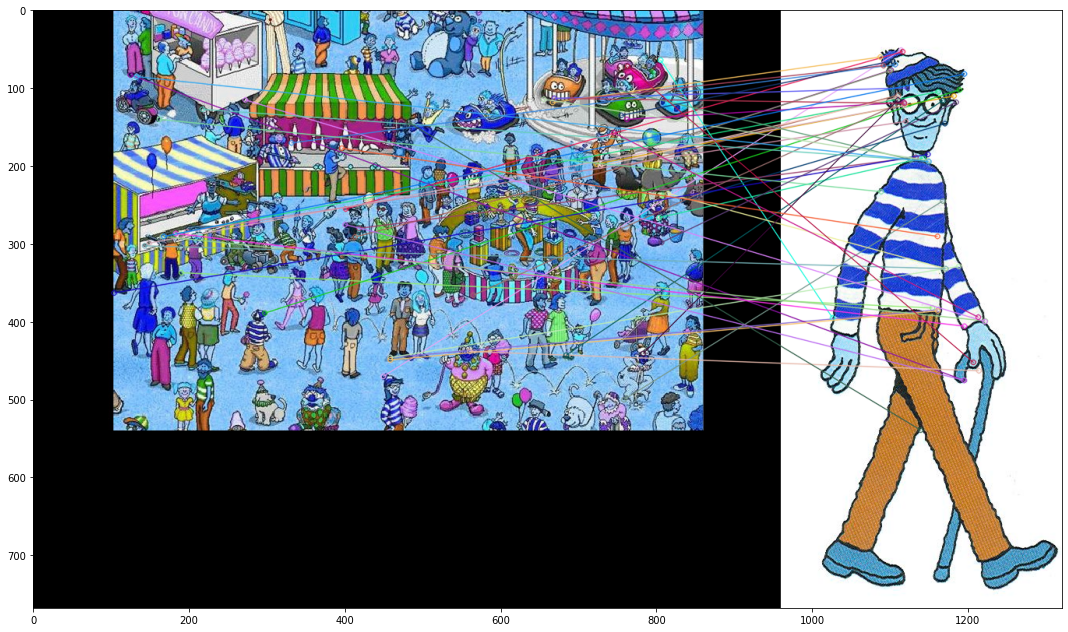

In [ ]:
out = cv2.drawMatches(img,kp1,ref,kp2,matches[:50],None,flags=2)
plt.figure(figsize=(22,11))
plt.imshow(out)
plt.show()

It can be observed that if the matcher is asked to only match once, then it accurately identifies waldo in this particular image

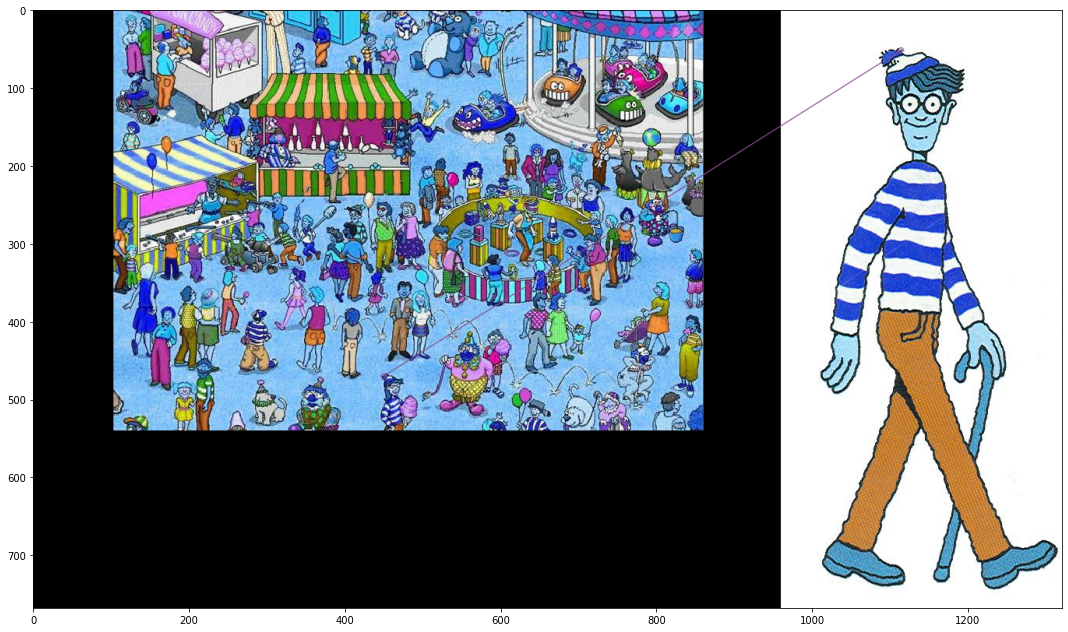

In [ ]:
out = cv2.drawMatches(img,kp1,ref,kp2,matches[:1],None,flags=2)
plt.figure(figsize=(22,11))
plt.imshow(out)
plt.show()

### Testing the algorithm on a new test image

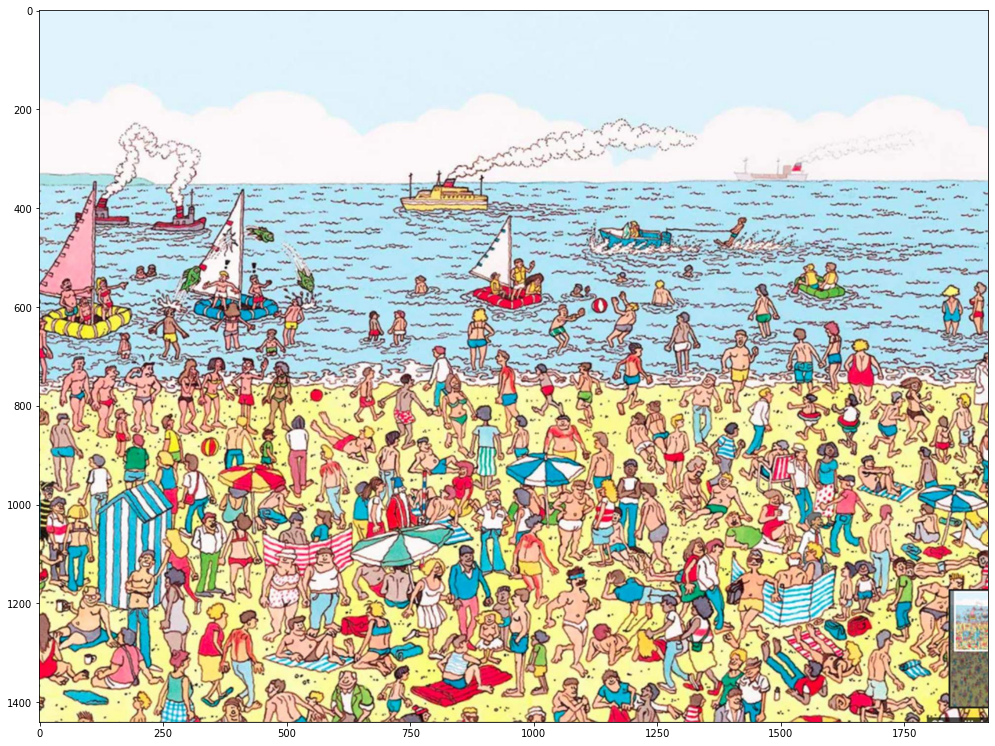

In [ ]:
img2 = cv2.imread('/content/drive/MyDrive/Personal_Projects/Waldo/Dataset/waldo4.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (17,17))
plt.imshow(img2)

In [ ]:
kp3,des3 = orb.detectAndCompute(img2,None)

In [ ]:
second_matches = bf.match(des3,des2)
second_matches = sorted(second_matches,key= lambda x:x.distance)

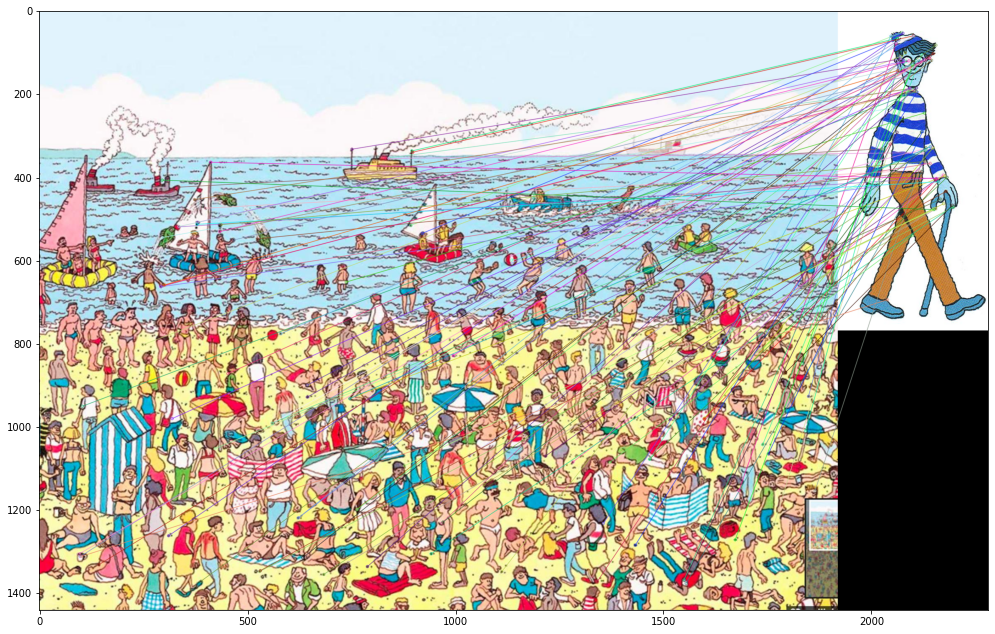

In [ ]:
out2 = cv2.drawMatches(img2,kp3,ref,kp2,matches[0:100],None,flags=2)
plt.figure(figsize=(17,17))
plt.imshow(out2)
plt.show()

In the above example, the algorithm breaks down because the matching is being done by comparing specific features. Waldo's face in the query image isn't very similar to the reference Waldo and the colour of the shirt is different, which breaks the algorithm

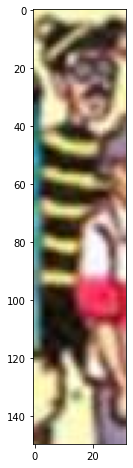

In [ ]:
waldo_annotated = img2[950:1100,0:32,:]
plt.figure(figsize=(8,8))
plt.imshow(waldo_annotated)

It's evidently quite clear that Waldo in this picture has a moustache. Yet we are able to identify Waldo and see the likeness without any trouble. Some of Waldo's most distinguishing features are the eyeglasses and striped shirt. It doesn't matter the color. But from a distance we spot the beanie cap and glasses and a striped pattern shirt and we know it's Waldo.

# Second Approach <br>
Using template matching in OpenCV. There is a catch however. Template matching requires almost exactly the same reference as the image of Waldo in the query image. So this method will fail if we are given a general image of Waldo and expected to compare.<br> [Reference article](https://www.pyimagesearch.com/wp-content/uploads/2014/11/opencv_crash_course_waldo.pdf)

In [ ]:
result = cv2.matchTemplate(img,extract,cv2.TM_CCOEFF)
(_,_,minLoc,maxLoc) = cv2.minMaxLoc(result)

In [ ]:
extract.shape

(90, 70, 3)

In [ ]:
waldoHeight, waldoWidth = extract.shape[:2]

In [ ]:
topleft = maxLoc
botright = (topleft[0] + waldoWidth,topleft[1] + waldoHeight)

In [ ]:
botright

(500, 540)

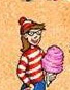

In [ ]:
cv2_imshow(extract)

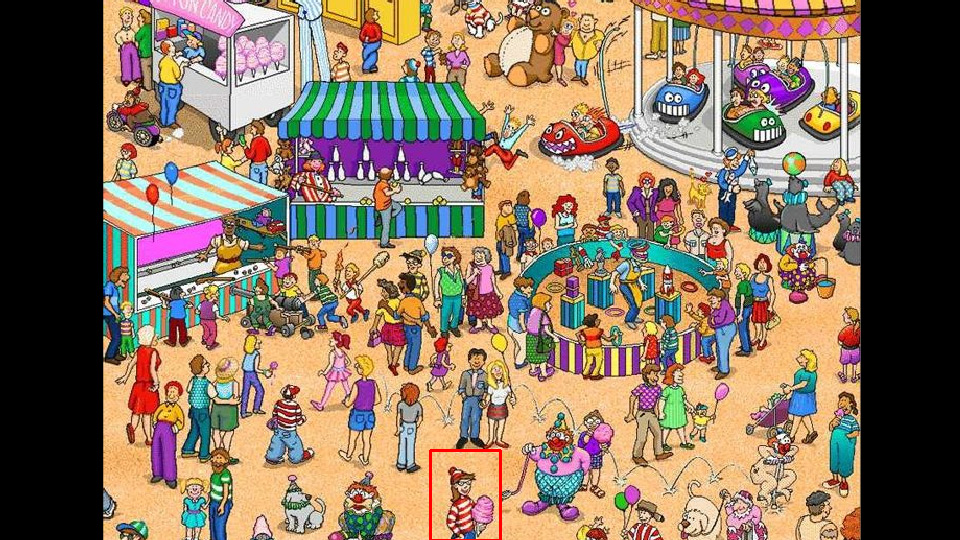

In [ ]:
final_res = cv2.rectangle(img,topleft,botright,(0,0,255),2) 
cv2_imshow(final_res)

# Third Approach: Building a Neural Network

Steps Involved: <br>
1. Preparing Labelled data for training (Since it is tedious to hand label training data, an [already configured training set](https://github.com/vc1492a/Hey-Waldo) is being used)<br>
2. Model Selection (Pre trained model from the Tensorflow Object Detection API)<br>
3. Training and Testing<br>
[Reference article](https://towardsdatascience.com/how-to-find-wally-neural-network-eddbb20b0b90)